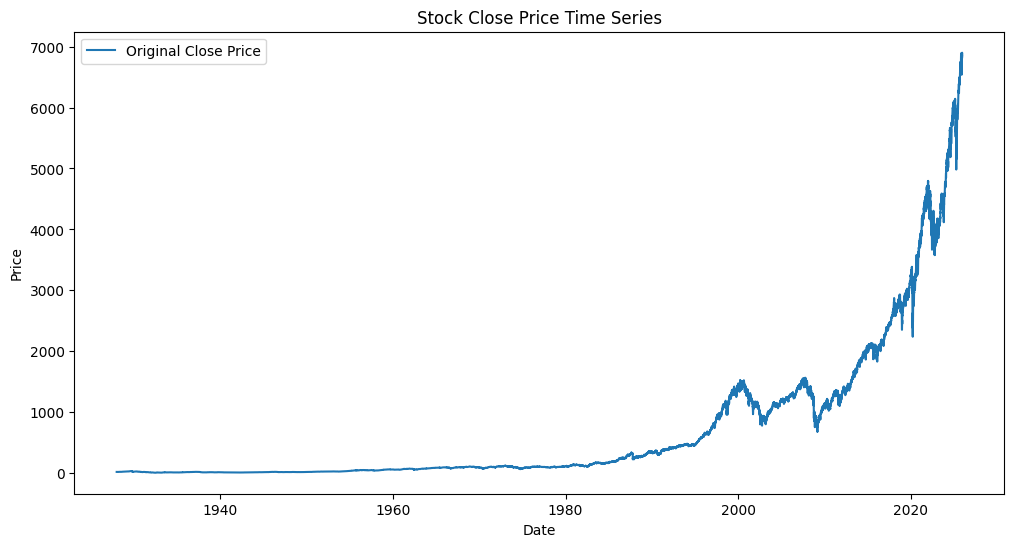

Results of ADF Test:
Test Statistic                     7.397165
p-value                            1.000000
#Lags Used                        47.000000
Number of Observations Used    24556.000000
Critical Value (1%)               -3.430616
Critical Value (5%)               -2.861658
Critical Value (10%)              -2.566833
dtype: float64

Series is NOT Stationary. Differencing needed.

--- Applying First Difference ---
Results of ADF Test:
Test Statistic                   -23.840085
p-value                            0.000000
#Lags Used                        46.000000
Number of Observations Used    24556.000000
Critical Value (1%)               -3.430616
Critical Value (5%)               -2.861658
Critical Value (10%)              -2.566833
dtype: float64

Series is Stationary (d=0).

Determined 'd' parameter (Integration): 1


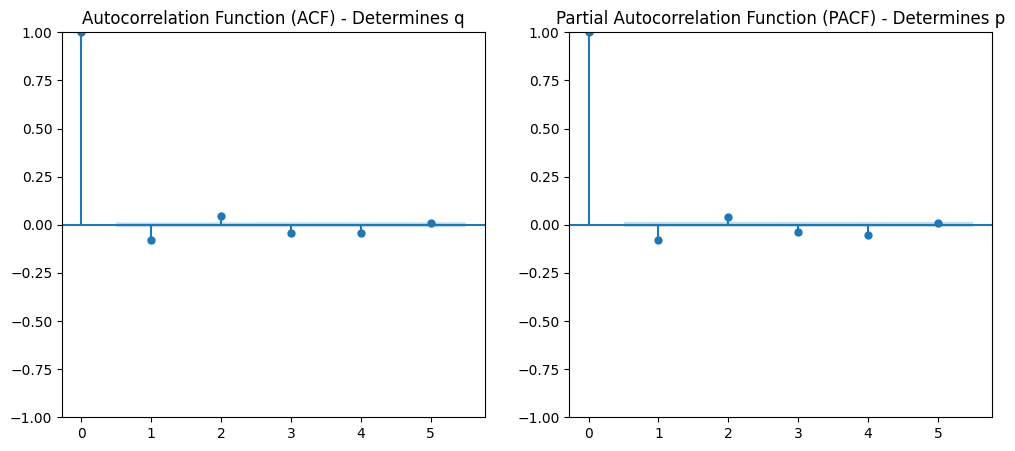


--- Interpretation for p and q ---
Look at the PACF plot (right): 'p' is the last significant spike.
Look at the ACF plot (left): 'q' is the last significant spike.
Using assumed parameters: p=1, q=1

Training on 24601 points. Testing on 3 points.


c:\new_works\datasciencecoursera\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\new_works\datasciencecoursera\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\new_works\datasciencecoursera\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                24601
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -101534.527
Date:                Sun, 14 Dec 2025   AIC                         203075.054
Time:                        23:23:46   BIC                         203099.385
Sample:                             0   HQIC                        203082.935
                              - 24601                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4353      0.013    -32.981      0.000      -0.461      -0.409
ma.L1          0.3564      0.014     26.076      0.000       0.330       0.383
sigma2       225.1927      0.293    768.497      0.0

c:\new_works\datasciencecoursera\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\new_works\datasciencecoursera\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


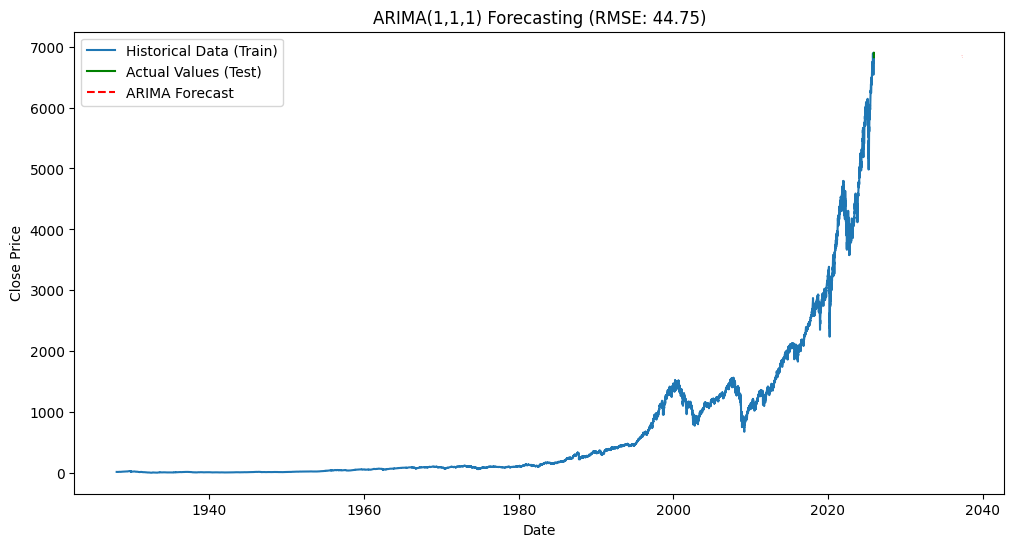

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# --- 1. Prepare and Load the Data ---
# Assuming 'df' is your DataFrame, we create a sample for demonstration

df = pd.read_csv('spx_historical_data.csv', parse_dates=['Date'])


# Set the 'Date' column as the index for time series analysis
ts_data = df.set_index('Date')['Close']

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Original Close Price')
plt.title('Stock Close Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# --- 2. Check for Stationarity (Determine 'd') ---
# Use the Augmented Dickey-Fuller (ADF) test
def check_stationarity(timeseries):
    print("Results of ADF Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    # The series is stationary if the p-value is <= 0.05
    if dfoutput['p-value'] <= 0.05:
        print("\nSeries is Stationary (d=0).")
        return 0
    else:
        print("\nSeries is NOT Stationary. Differencing needed.")
        return 1

d_initial = check_stationarity(ts_data)

# If not stationary (typical for stock prices), apply first differencing
if d_initial > 0:
    ts_diff = ts_data.diff().dropna()
    print("\n--- Applying First Difference ---")
    d = check_stationarity(ts_diff) + 1  # d will be 1 if one difference makes it stationary
    
    # Use the differenced series for ACF/PACF plots
    series_for_plots = ts_diff
else:
    d = 0
    series_for_plots = ts_data

print(f"\nDetermined 'd' parameter (Integration): {d}")

# --- 3. Identify AR and MA Lags (Determine 'p' and 'q') ---
# Plot ACF and PACF for the stationary series to help determine p and q
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(series_for_plots, ax=plt.gca(), lags=5)
plt.title('Autocorrelation Function (ACF) - Determines q')

plt.subplot(122)
plot_pacf(series_for_plots, ax=plt.gca(), lags=5, method='ols')
plt.title('Partial Autocorrelation Function (PACF) - Determines p')
plt.show()

print("\n--- Interpretation for p and q ---")
print("Look at the PACF plot (right): 'p' is the last significant spike.")
print("Look at the ACF plot (left): 'q' is the last significant spike.")
# **Note:** For this example, we'll assume p=1 and q=1 based on typical stock price differences.
p = 1
q = 1
print(f"Using assumed parameters: p={p}, q={q}")

# --- 4. Fit the ARIMA Model ---
# Split data into training and testing sets (e.g., last 3 points for test)
train_size = len(ts_data) - 3
train_data, test_data = ts_data[:train_size], ts_data[train_size:]

print(f"\nTraining on {len(train_data)} points. Testing on {len(test_data)} points.")

# Fit the ARIMA model
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# --- 5. Forecast and Evaluate ---
# Generate predictions for the length of the test data
start = len(train_data)
end = len(ts_data) - 1
forecast = model_fit.predict(start=start, end=end, dynamic=False)

# Create a DataFrame for visualization
forecast_df = pd.DataFrame(forecast.values, index=test_data.index, columns=['Forecast'])
results_df = pd.concat([test_data, forecast_df], axis=1)

# Calculate error
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Historical Data (Train)')
plt.plot(test_data, label='Actual Values (Test)', color='green')
plt.plot(forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.title(f'ARIMA({p},{d},{q}) Forecasting (RMSE: {rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# --- Optional: Forecast future steps beyond the test set ---
# forecast_steps = 5
# future_forecast = model_fit.predict(start=len(ts_data), end=len(ts_data) + forecast_steps - 1)
# print(f"\nForecast for the next {forecast_steps} steps:\n{future_forecast}")

<Axes: xlabel='Date'>

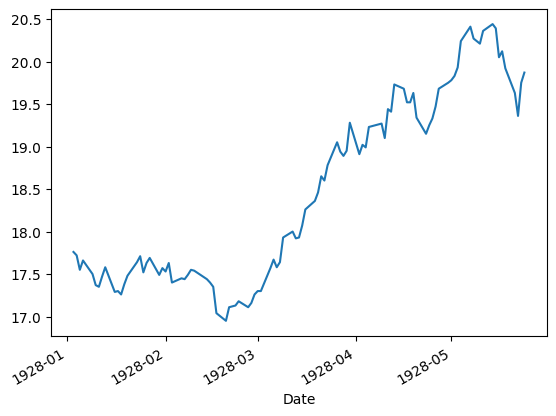

In [12]:
ts_data.head(100).plot()